In [ ]:
# 2.5h to complete, with one "Don't know" answer

In [1]:
import os
import pathlib
import random
import glob
import math

import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import seaborn as sns
import pandas as pd
import SimpleITK as sitk

from skimage import color, io, img_as_ubyte, img_as_float, segmentation, measure
from skimage.measure import profile_line
from skimage.transform import rescale, resize, rotate, EuclideanTransform, SimilarityTransform, warp, swirl, matrix_transform 
from skimage.morphology import erosion, dilation, opening, closing, disk, binary_closing, binary_opening
from skimage.color import label2rgb, rgb2gray
from skimage.filters import median, gaussian, prewitt_h, prewitt_v, prewitt, threshold_otsu

from sklearn import decomposition
from sklearn.decomposition import PCA

from scipy.ndimage import correlate
from scipy.stats import norm
from scipy.spatial import distance

## Track cars on light backgroud

In [2]:
# start: 9.48am

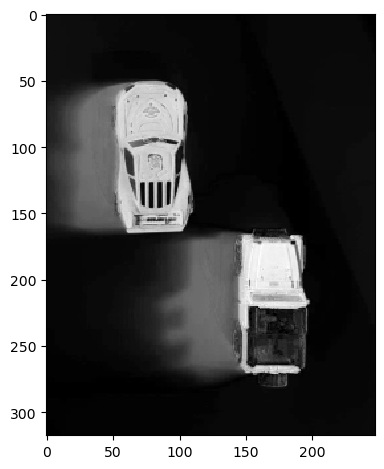

In [3]:
in_dir = "fall2022_data/"
im_name = "pixelwise.png"
input_img = io.imread(in_dir + im_name)
hsv_img = color.rgb2hsv(input_img)
sat_img = hsv_img[:, :, 1]
io.imshow(sat_img)
io.show()

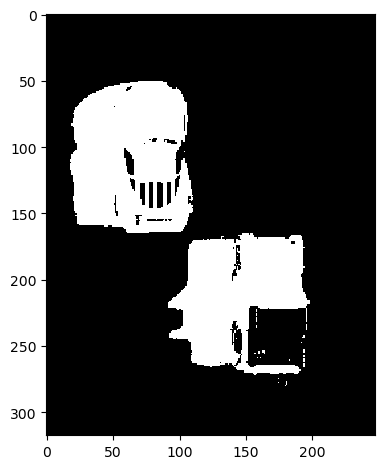

In [4]:
otsu_thres = threshold_otsu(sat_img)
bin_img = sat_img > otsu_thres
io.imshow(bin_img)
io.show()

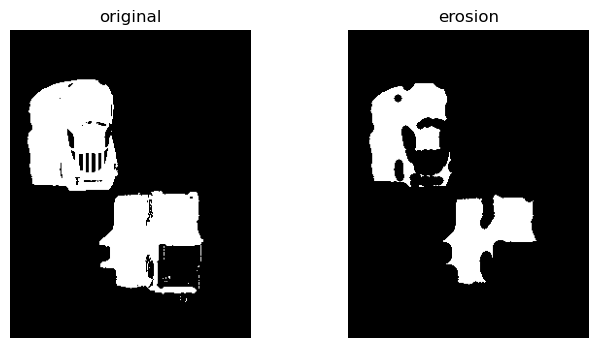

In [5]:
def plot_comparison(original, filtered, filter_name):
    """
    convenience function to show two images side by side:
    """
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    io.show()
    
eroded = erosion(bin_img, disk(4))
plot_comparison(bin_img, eroded, 'erosion')

In [6]:
print(eroded.shape)
bincount = np.bincount(eroded.flatten())
print("# foreground: ", bincount[1])

(318, 248)
# foreground:  10045


## CPH Sun

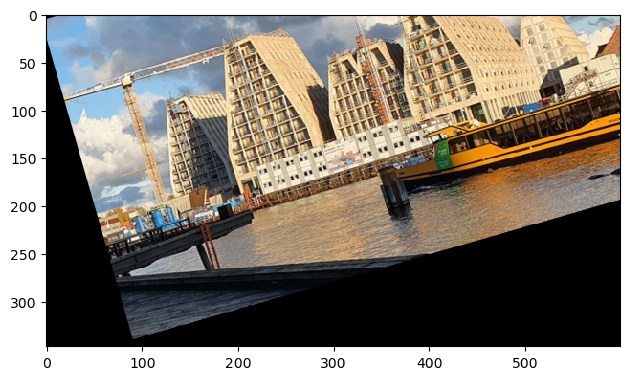

In [7]:
im_name = "CPHSun.png"
input_img = io.imread(in_dir + im_name)

rotation_angle = 16
rot_center = [20, 20]
rotated_img = rotate(input_img, rotation_angle, center=rot_center)
io.imshow(rotated_img)

In [8]:
from skimage import img_as_ubyte
ubyte_rotated = img_as_ubyte(rotated_img)
ubyte_rotated[200,200]

array([88, 91, 95], dtype=uint8)

## Blobs

In [9]:
def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified, cmap=plt.cm.gray)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

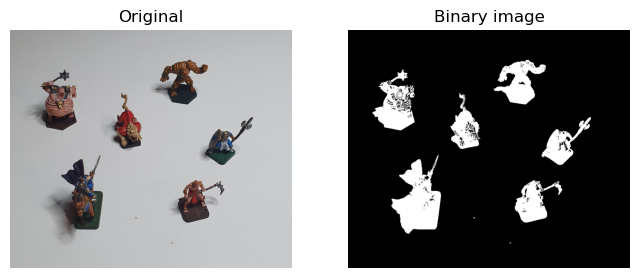

In [10]:
img_name = "figures.png"
input_img = io.imread(in_dir + img_name)
gray_img = rgb2gray(input_img)
otsu_thres = threshold_otsu(gray_img)
bin_img = gray_img < otsu_thres
show_comparison(input_img, bin_img, 'Binary image')

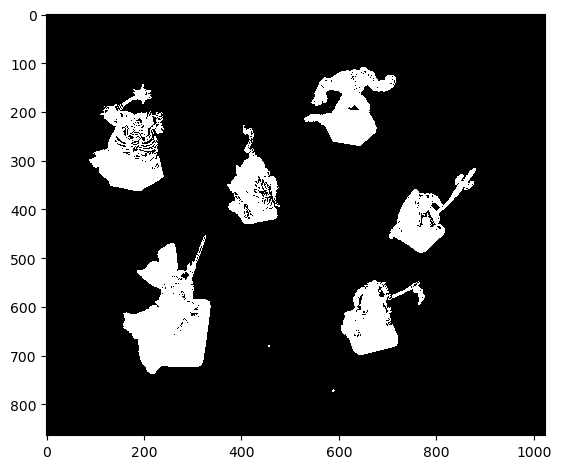

In [11]:
bin_img = segmentation.clear_border(bin_img)
io.imshow(bin_img)
io.show()

Number of labels: 31


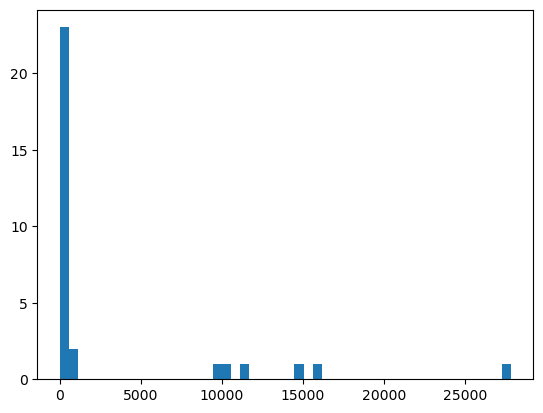

[14955   989 15947     5     3 10015     1    12     5     1 10351     1
     1     1     2     8    42     1     5     1     1    11     1     1
 27828     5 11438   858     4    17    15]


In [12]:
label_img = measure.label(bin_img)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50)
plt.show()
print(areas)

In [13]:
large_area = areas > 13000
print("# blobs > 13000 pixels: ", large_area.sum())

# blobs > 13000 pixels:  3


In [14]:
largest_blob = np.argmax(areas)
print(largest_blob)

perimeters = np.array([prop.perimeter for prop in region_props])
print(perimeters[largest_blob])

24
1998.35761056913


## Video Surveillance

In [15]:
change1_img = io.imread(in_dir + 'change1.png')
change2_img = io.imread(in_dir + 'change2.png')

gray1_img = rgb2gray(change1_img)
gray2_img = rgb2gray(change2_img)

diff = abs(gray1_img-gray2_img)
changed = diff > 0.3
print(changed.sum())
percentage = changed.sum()/(changed.shape[0]*changed.shape[1])
print(percentage)

7503
0.04560539752005835


In [16]:
changed.shape

(360, 457)

In [55]:
n_bytes = 1024*768*3
n_frames_transferred = 30*1e6/n_bytes

print("transfer fps: ", n_frames_transferred)
print("processing fps: ", 1/0.054)

transfer fps:  12.715657552083334
processing fps:  18.51851851851852


## Face Detection

In [18]:
white_l = 168+217+159+223
black = 178+60+155+252
white_r = 97+136+32+108
black - (white_l+white_r)

-495

In [19]:
# integral image
33+12+110+\
200+53+81+\
220+120+107

# end: 10.30am

936

## Abdominal

(512, 512)
int16


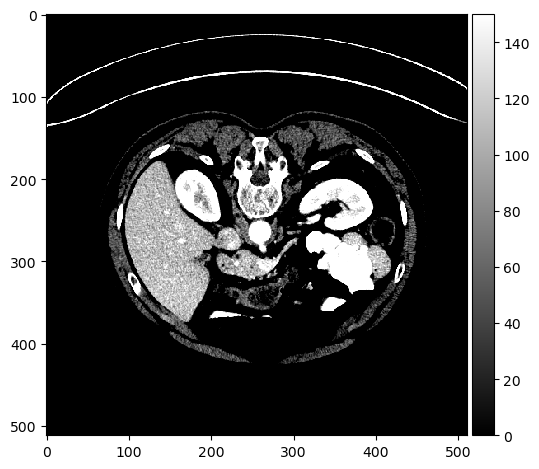

In [20]:
ct = dicom.read_file(in_dir + '1-162.dcm')
ct_img = ct.pixel_array
print(ct_img.shape)
print(ct_img.dtype)
io.imshow(ct_img, vmin=0, vmax=150, cmap='gray')
io.show()

In [21]:
ROI = ['LiverROI', 'KidneyROI', 'AortaROI']
mu_organs = []
std_organs = []
for roi in ROI:
    roi_img = io.imread(in_dir + roi + '.png')
    organ_mask = roi_img > 0
    organ_values = ct_img[organ_mask]
    mu_organ = np.mean(organ_values)
    std_organ = np.std(organ_values)
    mu_organs.append(mu_organ)
    std_organs.append(std_organ)
#     n, bins, patches = plt.hist(organ_values, 60, density=1)
#     pdf_spleen = norm.pdf(bins, mu_organ, std_organ)
#     plt.plot(bins, pdf_spleen)
#     plt.xlabel('Hounsfield unit')
#     plt.ylabel('Frequency')
#     plt.title(roi + ' values in CT scan')
#     plt.show()
    

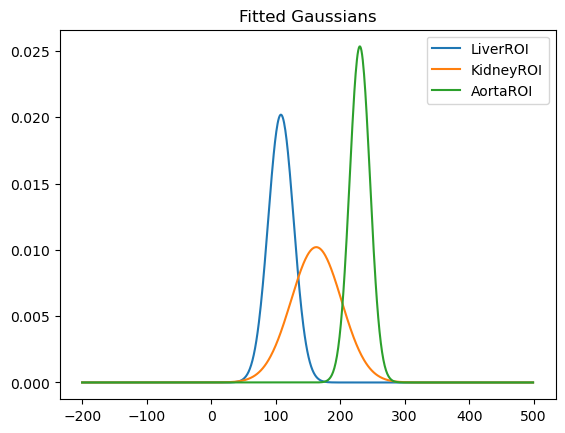

In [57]:
min_hu = -200
max_hu = 500
hu_range = np.arange(min_hu, max_hu, 1.0)

for i in range(len(ROI)):
    pdf_organ = norm.pdf(hu_range,mu_organs[i],std_organs[i])
    plt.plot(hu_range,pdf_organ,label=ROI[i])

plt.title("Fitted Gaussians")
plt.legend()
plt.show()

In [23]:
# take threshold as midpoint between 2 class value averages
t_background = -200
t1 = (mu_organs[0] + mu_organs[1])/ 2
t2 = (mu_organs[1] + mu_organs[2])/ 2
print(t1,t2)

135.53619417264818 196.7035801627044


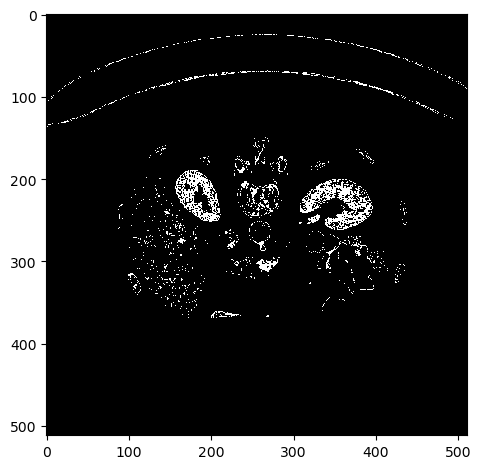

In [24]:
ct_bin = (ct_img>t1) & (ct_img<t2)
kidney_roi_img = io.imread(in_dir+'KidneyROI.png')

ct_bin.sum()
kidney_roi_img.sum()
# io.imshow(kidney_roi_img)
io.imshow(ct_bin)
# kidney_roi_img

In [58]:
gt_bin = kidney_roi_img > 0
dice_score = 1 - distance.dice(ct_bin.ravel(), gt_bin.ravel())
print(dice_score)

0.24143337066069426


## Hough Space

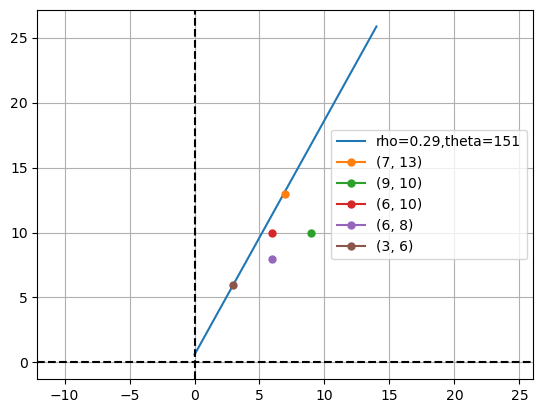

In [26]:
rhos=[0.29]
thetas=[151]

x = range(0,15)
for rho,theta in zip(rhos,thetas):
#     theta=theta+90
    theta_rad = np.deg2rad(theta)
    cot = 1/np.tan(theta_rad)
    cosec = 1/np.sin(theta_rad)
    y = x*(-cot)+rho*cosec
    plt.plot(x,y,label=f'rho={rho},theta={theta}')

points = [(7,13),(9,10),(6,10),(6,8),(3,6)]
for point in points:
    plt.plot(point[0],point[1],marker="o", markersize=5,label=point)

plt.axvline(x=0, c="black",ls='--')
plt.axhline(y=0, c="black",ls='--')
plt.legend()
plt.axis('equal')
plt.grid()
plt.show()

## Rocket Transform

In [27]:
src = [(220, 55), (105, 675), (315, 675)]
dst = [(100, 165), (200, 605), (379, 525)]

F = 0
for i in range(len(src)):
    dist = distance.euclidean(src[i], dst[i])
    F += dist**2
print("F: ", F)


F:  67021.0


In [28]:
src = np.array([(220, 55), (105, 675), (315, 675)])
dst = np.array([(100, 165), (200, 605), (379, 525)])

e_x = src[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)

e_y = src[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)

f = error_x + error_y
print(f"Landmark alignment error F: {f}")

Landmark alignment error F: 67021


In [29]:
from skimage.transform import rotate, EuclideanTransform, SimilarityTransform, \
    warp, swirl, matrix_transform 
# find optimal transform of src points/landmarks
tform = EuclideanTransform()
tform.estimate(src, dst)
src_transform = matrix_transform(src, tform.params)
print(src_transform)

[[ 50.79448827  57.40071475]
 [219.77090535 664.91365327]
 [408.43460638 572.68563198]]


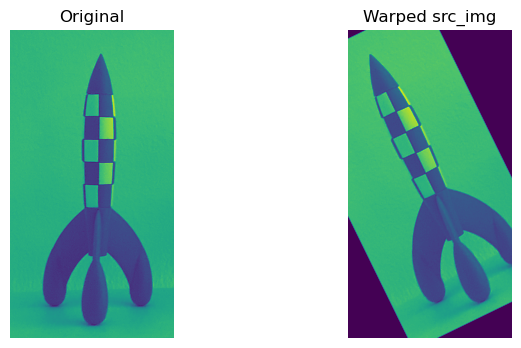

129

In [30]:
def show_comparison(original, transformed, transformed_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original)
    ax2.imshow(transformed)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.set_title(transformed_name)
    ax2.axis('off')
    io.show()

src_img = io.imread(in_dir + 'rocket.png')
warped = warp(src_img, tform.inverse)
show_comparison(src_img, warped, "Warped src_img")
ubyte_warped = img_as_ubyte(warped)
ubyte_warped[150,150]

In [31]:
e_x = src_transform[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)

e_y = src_transform[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)

f = error_x + error_y
print(f"Landmark alignment error F: {f}")

# 1h40min to finish up to page 9

Landmark alignment error F: 21119.638667058513


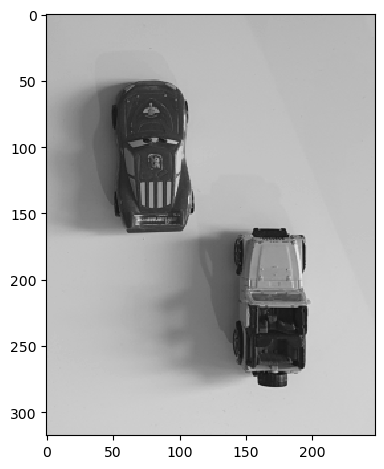

In [32]:
# start 9.37pm
img_name = "pixelwise.png"
input_img = io.imread(in_dir + img_name)
gray_img = rgb2gray(input_img)
float_img = img_as_float(gray_img)
io.imshow(float_img)
io.show()

In [33]:
print("min value: ", float_img.min())
print("max value: ", float_img.max())
# full scale of gray-scale spectrum is not used
# picture can be further enhanced

min value:  0.05569764705882353
max value:  0.9173427450980393


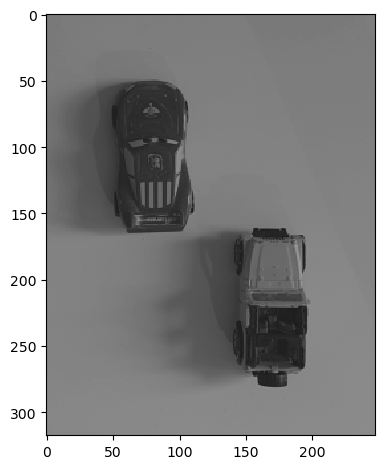

In [34]:
def histogram_stretch(img_in):
    """
    Stretches the histogram of an image 
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = 0.1
    max_desired = 0.6

    img_out = img_float
    for i in range(img_in.shape[0]):
        for j in range(img_in.shape[1]):
            new = (img_float[i,j] - min_val)*(max_desired - min_desired)/(max_val - min_val) + min_desired
            img_out[i,j] = new
    
    return img_out

im_stretched = histogram_stretch(float_img)
io.imshow(im_stretched)
io.show()

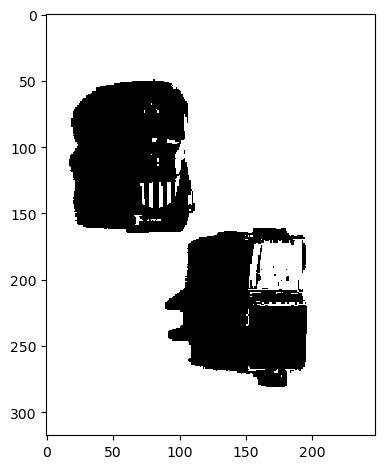

Otsu threshold:  0.3724609375


In [35]:
otsu_thres = threshold_otsu(im_stretched)
bin_img = im_stretched > otsu_thres
io.imshow(bin_img)
io.show()
print("Otsu threshold: ", otsu_thres)

## LDA

In [73]:
# from LDA import LDA

# The @ operator is a matrix multiplication operator

pooled_cov = 2 * np.eye(2)
group_mean = np.array([[24, 3], [30, 7]])
x = np.array([[23], [5]])
group_diff = group_mean[1, :] - group_mean[0, :]
group_diff = group_diff[:, None]

w = np.linalg.inv(pooled_cov) @ group_diff
c = -0.5 * np.sum(group_mean, axis=0, keepdims=True)
w0 = c @ w
y = x.T @ w + w0
print(y)

[[-12.]]


In [74]:
pooled_cov = 2 * np.eye(2)  # or 4*np.eye(2)?
group_mean = np.array([[24, 3], [30, 7]])
prior_prob = np.array([[0.5], [0.5]])
m = 2  # no. of dimensions
k = 2  # no. of classes
W = np.zeros((k, m + 1))

for i in range(k):
    # Intermediate calculation for efficiency
    temp = group_mean[i, :][np.newaxis] @ np.linalg.inv(pooled_cov)
    # Constant
    W[i, 0] = -0.5 * temp @ group_mean[i, :].T + np.log(prior_prob[i])
    # Linear
    W[i, 1:] = temp

Y = np.array([[1, 23, 5]]) @ W.T
posteriorProb = np.clip(np.exp(Y) / np.sum(np.exp(Y), 1)[:, np.newaxis], 0, 1)

print('Y: ',Y)
print(f'Posterior Prob: {posteriorProb}')
print(f'Assigned class: {np.argmax(posteriorProb)+1}')

Y:  [[136.55685282 124.55685282]]
Posterior Prob: [[9.99993856e-01 6.14417460e-06]]
Assigned class: 1


In [77]:
np.exp(Y)

array([[2.02249588e+59, 1.24266442e+54]])

## Animal Sorting

In [37]:
cows = [26, 46, 33, 23, 35, 28, 21, 30, 38, 43]
sheep = [67, 27, 40, 60, 39, 45, 27, 67, 43, 50, 37, 100]

mu_cows = np.mean(cows)
std_cows = np.std(cows)
mu_sheep = np.mean(sheep)
std_sheep = np.std(sheep)

# Min. distance classifier
thres = (mu_cows + mu_sheep)/ 2
print("Min. dist threshold: ", thres)

Min. dist threshold:  41.233333333333334


In [38]:
test_value = 38
print("cows: ", round(norm.pdf(test_value, mu_cows, std_cows),2))
print("sheep: ", round(norm.pdf(test_value, mu_sheep, std_sheep),2))

cows:  0.04
sheep:  0.02


## Car Data

In [13]:
txt_name = "car_data.txt"
data = np.loadtxt(in_dir + txt_name, comments="%")

# Check matric dimensions
n_feat = data.shape[1]   # columns
n_obs = data.shape[0]    # rows
print(f"Number of features: {n_feat} and number of observations: {n_obs}")

Number of features: 8 and number of observations: 203


In [17]:
mu_x = np.mean(data, axis=0)
std_x = np.std(data, axis=0)

# pre-processing
x = data
for i in range(n_feat):
    x[:,i] = (x[:,i]-mu_x[i])/std_x[i]   # standardize
#     x[:,i] = x[:,i]/std_x[i]   # normalize

print(np.mean(x,axis=0))
print(np.var(x,axis=0))

covariance = np.cov(x.transpose())
# print("\n Using numpy covariance: \n", covariance)

[-2.21388315e-14  2.06906194e-14  8.33050104e-15  1.31509472e-14
 -1.91034927e-15 -2.70199845e-15 -7.92606265e-16 -7.41060196e-16]
[1. 1. 1. 1. 1. 1. 1. 1.]


In [18]:
x[0][0]

-1.6884672145358408

In [8]:
# Direct PCA using the decompositions functions

pca = decomposition.PCA()
pca.fit(x)
values_pca = pca.explained_variance_
exp_var_ratio = pca.explained_variance_ratio_
vectors_pca = pca.components_

x_transform = pca.transform(x)
print("shape: ", x_transform.shape)


shape:  (203, 8)


In [9]:
x_transform[0][0]

-1.1282393391042858

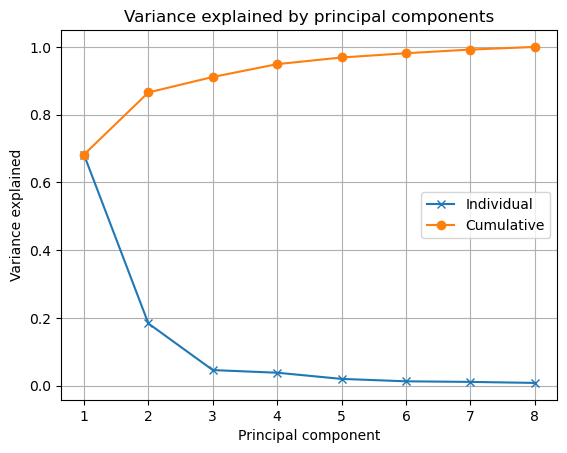

In [43]:
plt.figure()
plt.plot(range(1, len(exp_var_ratio)+1), exp_var_ratio, 'x-')
plt.plot(range(1, len(exp_var_ratio)+1), np.cumsum(exp_var_ratio), 'o-')
plt.title('Variance explained by principal components')
plt.xlabel('Principal component')
plt.ylabel('Variance explained')
plt.legend(['Individual', 'Cumulative'])
plt.grid()
plt.show()

In [44]:
np.cumsum(exp_var_ratio)

array([0.68205515, 0.865523  , 0.91125231, 0.94915175, 0.96881995,
       0.98137998, 0.99219665, 1.        ])

<Figure size 640x480 with 0 Axes>

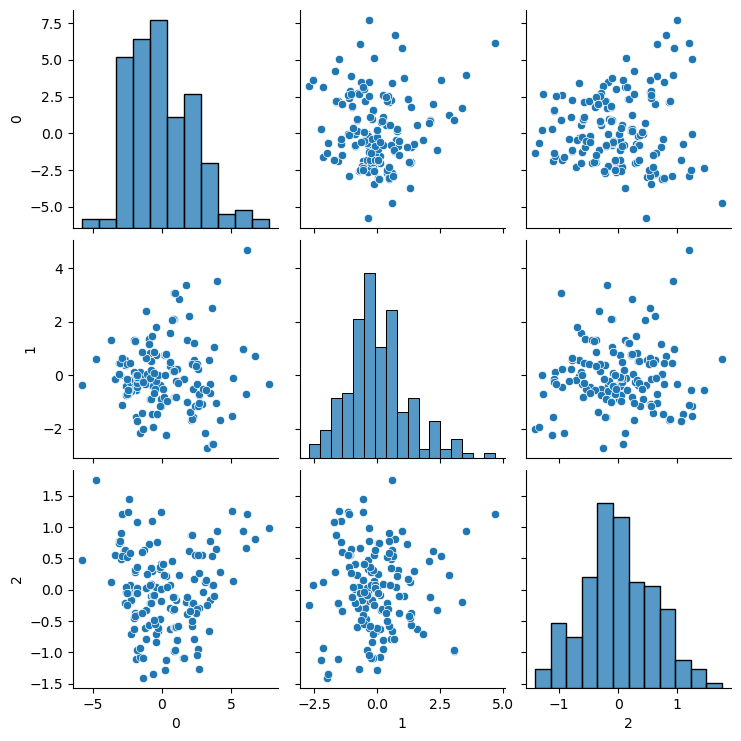

In [47]:
# Using seaborns pairplot with projected data
plt.figure()
d = pd.DataFrame(x_transform[:,0:3])    # first 3 attributes
sns.pairplot(d)
plt.show()

## Noise Filtering

In [48]:
input_img = io.imread(in_dir + 'rocket.png')

sigma = 3   # std of gaussian filter
gauss_img = gaussian(input_img, sigma)
ubyte_img = img_as_ubyte(gauss_img)

ubyte_img[100][100]

123

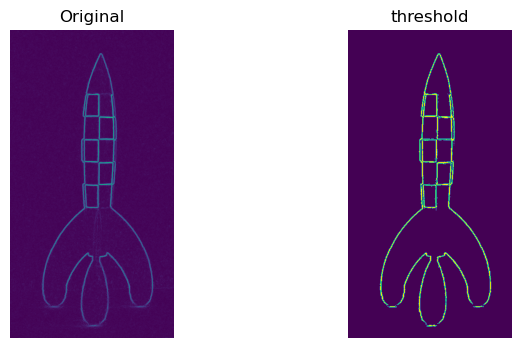

In [49]:
edges = prewitt(input_img)
threshold = edges > 0.06
show_comparison(edges,threshold,'threshold')

In [50]:
threshold.sum()

# end: 10.35pm

8885